In [1]:
import cv2
import mediapipe as mp
from matplotlib import pyplot as plt
import numpy as np

In [2]:
img = cv2.imread("vin_diesel.jpg")
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

img2 = cv2.imread("will_smith.jpg")
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(img2,cv2.COLOR_BGR2RGB)

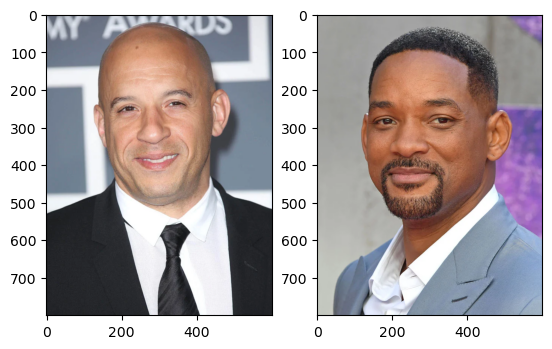

In [3]:
fig, axs = plt.subplots(1,2)
axs[0].imshow(img)
axs[1].imshow(img2)


In [4]:
from mediapipe.python.solutions import drawing_utils as mp_drawing
import mediapipe.python.solutions.face_mesh as mp_faces
from mediapipe.python.solutions import drawing_styles
import puntos_cara

lista_puntos = puntos_cara.FACEMESH_TESSELATION

lista_triangulos = [lista_puntos[i:i+3] for i in range(0,len(lista_puntos),3)]

lista_tri_simple = [[t[0][0], t[1][0], t[2][0]] for t in lista_triangulos]
lista_tri_simple

[[127, 34, 139],
 [11, 0, 37],
 [232, 231, 120],
 [72, 37, 39],
 [128, 121, 47],
 [232, 121, 128],
 [104, 69, 67],
 [175, 171, 148],
 [118, 50, 101],
 [73, 39, 40],
 [9, 151, 108],
 [48, 115, 131],
 [194, 204, 211],
 [74, 40, 185],
 [80, 42, 183],
 [40, 92, 186],
 [230, 229, 118],
 [202, 212, 214],
 [83, 18, 17],
 [76, 61, 146],
 [160, 29, 30],
 [56, 157, 173],
 [106, 204, 194],
 [135, 214, 192],
 [203, 165, 98],
 [21, 71, 68],
 [51, 45, 4],
 [144, 24, 23],
 [77, 146, 91],
 [205, 50, 187],
 [201, 200, 18],
 [91, 106, 182],
 [90, 91, 181],
 [85, 84, 17],
 [206, 203, 36],
 [148, 171, 140],
 [92, 40, 39],
 [193, 189, 244],
 [159, 158, 28],
 [247, 246, 161],
 [236, 3, 196],
 [54, 68, 104],
 [193, 168, 8],
 [117, 228, 31],
 [189, 193, 55],
 [98, 97, 99],
 [126, 47, 100],
 [166, 79, 218],
 [155, 154, 26],
 [209, 49, 131],
 [135, 136, 150],
 [47, 126, 217],
 [223, 52, 53],
 [45, 51, 134],
 [211, 170, 140],
 [67, 69, 108],
 [43, 106, 91],
 [230, 119, 120],
 [226, 130, 247],
 [63, 53, 52],
 [23


# Visualization utilities


In [8]:
from mediapipe import solutions

def obtener_coordenadas(detection_result,img):
  face_landmarks_list = detection_result.face_landmarks

  puntos_coordenadas = []

  for idx in range(len(face_landmarks_list)):
    face_landmarks = face_landmarks_list[idx]
    
    for landmark in face_landmarks:
        
      coordenadas = []

      coordenadas.append(landmark.x)
      coordenadas.append(landmark.y)
      # coordenadas.append(landmark.z)

      puntos_coordenadas.append(coordenadas)

    puntos_coordenadas = np.array(puntos_coordenadas) 
    puntos_coordenadas = np.round(puntos_coordenadas * np.array([img.shape[1], img.shape[0]])).astype(int)

  return puntos_coordenadas

def print_face_lines(image,lista_triangulos,coordenadas):

  #Obtener los puntos. Las coordenadas de esos puntos. Unir los puntos

  for tr in lista_triangulos:
      pt1 = coordenadas[tr[0]]
      pt2 = coordenadas[tr[1]]
      pt3 = coordenadas[tr[2]]
      cv2.line(image, (pt1[0], pt1[1]),  (pt2[0], pt2[1]),  (0, 255, 0), thickness=1)
      cv2.line(image, (pt2[0], pt2[1]),  (pt3[0], pt3[1]),  (0, 255, 0), thickness=1)
      cv2.line(image, (pt1[0], pt1[1]),  (pt3[0], pt3[1]),  (0, 255, 0), thickness=1)   

#Se le pasa la lista de los puntos formando triangulos de la cara, las coordenadas de cada punto de esos triangulos,
#la imagen a la que queremos sacar la cara, la imagen a la que le queremos aplicar la cara de la imagen anterior
def triangulation_of_both_faces(lista_triangulos,coordenadas_img1,coordenadas_img2,img_gray_mask,img_new_face):
  
  height, width, channels = img_new_face.shape
  img2_new_face = np.zeros((height, width, channels), np.uint8)

  points_img1 = np.array(coordenadas_img1, np.int32)
  # convexhull_img1 = cv2.convexHull(points_img1)

  points_img2 = np.array(coordenadas_img2, np.int32)
  convexhull_img2 = cv2.convexHull(points_img2)

  # lines_space_mask = np.zeros_like(img_gray_mask)
  # lines_space_new_face = np.zeros_like(img_new_face)

  for tr in lista_triangulos:
    img1_pt1 = coordenadas_img1[tr[0]]
    img1_pt2 = coordenadas_img1[tr[1]]
    img1_pt3 = coordenadas_img1[tr[2]]

    #Obtenemos uno de los triangulos de la cara        
    #triangle1 = np.array(tr, np.int32)
    triangle1 = np.array([img1_pt1, img1_pt2, img1_pt3], dtype=np.int32)
    #Creamos un rectangulo que contenga el triangulo dado
    rect1 = cv2.boundingRect(triangle1)
    #Obtenemos las dimensiones del rectangulo resultante
    (x, y, w, h) = rect1
    #Sacamos de la imagen el triangulo
    cropped_triangle = img[y: y + h, x: x + w]
    #Creamos la mascara, un array de ceros de las mismas dimensiones que el rectangulo que contiene el triángulo
    cropped_tr1_mask = np.zeros((h, w), np.uint8)

    #pasarle las coordenadas del punto correspondiente
    points_img1 = np.array([[img1_pt1[0] - x, img1_pt1[1] - y],
                       [img1_pt2[0] - x, img1_pt2[1] - y],
                       [img1_pt3[0] - x, img1_pt3[1] - y]], np.int32)

    cv2.fillConvexPoly(cropped_tr1_mask, points_img1, 255)

    # Lines space
    # cv2.line(lines_space_mask, img1_pt1, img1_pt2, 255)
    # cv2.line(lines_space_mask, img1_pt2, img1_pt3, 255)
    # cv2.line(lines_space_mask, img1_pt1, img1_pt3, 255)
    # lines_space = cv2.bitwise_and(img, img, mask=lines_space_mask)

    # Triangulation of second face
    tr2_pt1 = coordenadas_img2[tr[0]]
    tr2_pt2 = coordenadas_img2[tr[1]]
    tr2_pt3 = coordenadas_img2[tr[2]]
    triangle2 = np.array([tr2_pt1, tr2_pt2, tr2_pt3], np.int32)

    rect2 = cv2.boundingRect(triangle2)
    (x, y, w, h) = rect2

    cropped_tr2_mask = np.zeros((h, w), np.uint8)

    points_img2 = np.array([[tr2_pt1[0] - x, tr2_pt1[1] - y],
                        [tr2_pt2[0] - x, tr2_pt2[1] - y],
                        [tr2_pt3[0] - x, tr2_pt3[1] - y]], np.int32)

    cv2.fillConvexPoly(cropped_tr2_mask, points_img2, 255)

    # Warp triangles
    points_img1 = np.float32(points_img1)
    points_img2 = np.float32(points_img2)
    M = cv2.getAffineTransform(points_img1, points_img2)
    warped_triangle = cv2.warpAffine(cropped_triangle, M, (w, h))
    warped_triangle = cv2.bitwise_and(warped_triangle, warped_triangle, mask=cropped_tr2_mask)

    # Reconstructing destination face
    img2_new_face_rect_area = img2_new_face[y: y + h, x: x + w]
    img2_new_face_rect_area_gray = cv2.cvtColor(img2_new_face_rect_area, cv2.COLOR_BGR2GRAY)
    _, mask_triangles_designed = cv2.threshold(img2_new_face_rect_area_gray, 1, 255, cv2.THRESH_BINARY_INV)
    warped_triangle = cv2.bitwise_and(warped_triangle, warped_triangle, mask=mask_triangles_designed)

    img2_new_face_rect_area = cv2.add(img2_new_face_rect_area, warped_triangle)
    img2_new_face[y: y + h, x: x + w] = img2_new_face_rect_area

  # Face swapped (putting 1st face into 2nd face)
  img2_face_mask = np.zeros_like(img2_gray)
  img2_head_mask = cv2.fillConvexPoly(img2_face_mask, convexhull_img2, 255)
  img2_face_mask = cv2.bitwise_not(img2_head_mask)


  img2_head_noface = cv2.bitwise_and(img2, img2, mask=img2_face_mask)
  result = cv2.add(img2_head_noface, img2_new_face)

  (x, y, w, h) = cv2.boundingRect(convexhull_img2)
  center_face2 = (int((x + x + w) / 2), int((y + y + h) / 2))

  seamlessclone = cv2.seamlessClone(result, img2, img2_head_mask, center_face2, cv2.NORMAL_CLONE)

  cv2.imshow("FaceSwap", seamlessclone)
  cv2.waitKey(0)

  cv2.destroyAllWindows()

In [11]:
import os
from mediapipe.framework.formats import landmark_pb2


file1 = 'blaze_face_short_range.tflite'
file2 = 'face_landmarker.task'

file_path =  os.path.abspath(file2)

BaseOptions = mp.tasks.BaseOptions
FaceLandmarker = mp.tasks.vision.FaceLandmarker
FaceLandmarkerOptions = mp.tasks.vision.FaceLandmarkerOptions
VisionRunningMode = mp.tasks.vision.RunningMode

options = FaceLandmarkerOptions(
    base_options=BaseOptions(model_asset_path=file_path),
    running_mode=VisionRunningMode.IMAGE)

with FaceLandmarker.create_from_options(options) as landmarker:
  # The landmarker is initialized. Use it here.
    # Load the input image from an image file.
    # mp_image = mp.Image.create_from_file('/path/to/image')

    # Load the input image from a numpy array.
    mp_image2 = mp.Image(image_format=mp.ImageFormat.SRGB, data=img2)
    
    # Perform face landmarking on the provided single image.
    # The face landmarker must be created with the image mode.
    face_landmarker_result = landmarker.detect(mp_image2)

    coordenadas_img2 = obtener_coordenadas(face_landmarker_result,img2)

    mp_image1 = mp.Image(image_format=mp.ImageFormat.SRGB, data=img)
    
    face_landmarker_result = landmarker.detect(mp_image1)

    coordenadas_img1 = obtener_coordenadas(face_landmarker_result,img)

    # print_face_lines(img,lista_tri_simple,coordenadas_img1)

    triangulation_of_both_faces(lista_tri_simple,coordenadas_img1,coordenadas_img2,img,img2)

    # plt.imshow(img)